# QTN Compressed Velocity Field Solution:

Using qiskit, qiskit-algorithms and the qmprs tool.

In [1]:
#!pip install qiskit==1.3.1
#!pip install qiskit-algorithms==0.3.1

In [2]:
#!pip install git+https://github.com/Qualition/qmprs.git

### Outline:
<ol>
<li>Introduction</li>
<li>Required imports</li>
<li>Initial step</li>
<li>MPS circuit representation using qmprs</li>
<li>Preparing the circuits</li>
<li>Running the solution</li>
<li>Running for more than 1 step</li>
<li>References</li>
<li>Versions</li>
</ol>

### Introduction:

Burger's equation contains a nonlinear term multiplied by $u$ and a linear term. But quantum computing is linear, so we change the nonlinear burger's equation into a linear equation that still models the characterisitcs of the original non-linear equation. For this transformation we use the Cole-hopf transformation.

The following image shows the genral steps of the algorithm, the detailed code and more explanation of each step will be shown in the following sections.

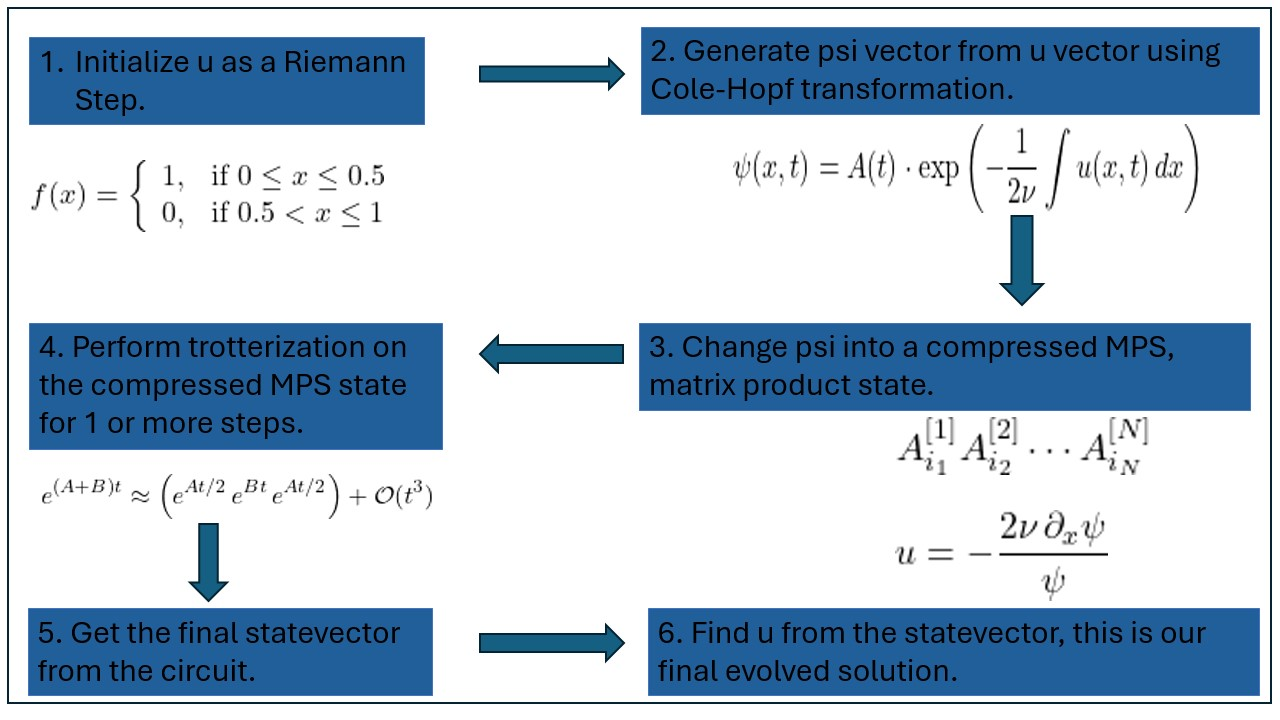

### Required imports:

In [3]:
import numpy as np
from quick.circuit import QiskitCircuit
from qmprs.synthesis.mps_encoding import Sequential
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit
import qiskit.qasm2 as qasm2
from qiskit import transpile

import warnings
warnings.filterwarnings('ignore')

In [4]:
from qiskit.quantum_info import Statevector, Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from scipy.sparse import diags

### Initial step:

Several shapes can be choosen as a starting step for the Burger's 1D equation but the project specifies a specific starting shape which is a riemann step, the following function builds a numpy vector representing this step exactly.

In [5]:
def riemann_step(N):
    """
    Create a Riemann step function of length N as a NumPy float array.

    Parameters:
    - N (int): even number representing the total number of grid points.

    Returns:
    - (ndarray): An array representing the Riemann step of half 1's then half 0's.
    """
    half = N // 2
    return np.concatenate([
        np.ones(half, dtype=np.float64),
        np.zeros(N - half, dtype=np.float64)
    ])

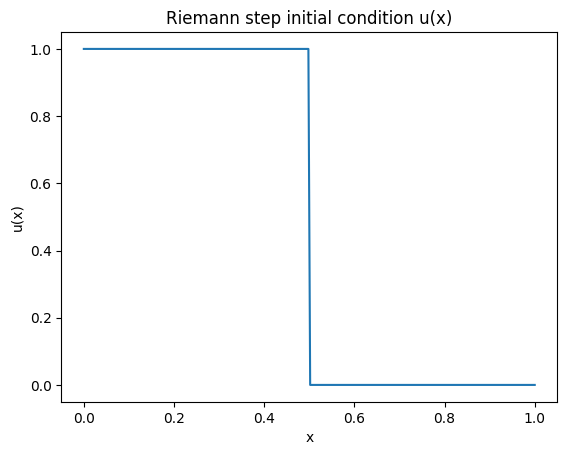

In [6]:
u = riemann_step(2**8)
plt.plot(np.linspace(0, 1, 2**8), u, label="u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Riemann step initial condition u(x)")
plt.show()

The function $f(x)$ in the image above represents a riemann step function which is our initial starting vector $u(x)$.

### MPS circuit representation using qmprs:

The guidlines of the project state clearly that in the paper explaining the QTN approach, an MPS, matrix product state, representation of the velocity vector $u$ is used and is the backbone of the paper and their approach.

Although qiskit does not have such a built-in feature and uses other encoding techniques like amplitude encoding and functions like "initialize", the qmprs tool has this feature and can build an MPS circuit representation of a vector as a qiskit circuit. This is what we will show in this section.

In [7]:
u4 = riemann_step(2**4) # 4 qubits MPS
u6 = riemann_step(2**6) # 6 qubits MPS
u8 = riemann_step(2**8) # 8 qubits MPS

First, we have generated 3 vectors with different number of qubits, which leads to different grid sizes to compare later our solution for trotterization using these different sizes.

Before building our MPS circuits we need to first transform vector $u$ into a vector $\psi$ as shown in step 2 in the image for Cole-hopf transformation.

$\psi(x,t) = A(t) \cdot \exp\left( -\frac{1}{2\nu} \int u(x,t) \, dx \right)
$

In [8]:
num_qubits = 4
N = 2**num_qubits     # Number of spatial points
L = 1.0               # Length of domain
dx = L / N
nu = 0.01             # Viscosity

psi4 = np.exp(-0.5 / nu * np.cumsum(u4) * dx)

# normalize
psi4 /= np.linalg.norm(psi4)

In [9]:
num_qubits = 6
N = 2**num_qubits     # Number of spatial points
L = 1.0               # Length of domain
dx = L / N
nu = 0.01             # Viscosity

psi6 = np.exp(-0.5 / nu * np.cumsum(u6) * dx)

# normalize
psi6 /= np.linalg.norm(psi6)

In [10]:
num_qubits = 8
N = 2**num_qubits     # Number of spatial points
L = 1.0               # Length of domain
dx = L / N
nu = 0.01             # Viscosity

psi8 = np.exp(-0.5 / nu * np.cumsum(u8) * dx)

# normalize
psi8 /= np.linalg.norm(psi8)

Now, we have finished building the vectors $u$ and $\psi$ for 3 different number of qubits 4, 6 and 8. In the following cells we will use the tool qmprs to transform these circuits into an MPS circuit for each $\psi$.

In [11]:
# Initialize the encoder with the preferred circuit backend
encoder = Sequential(QiskitCircuit)

In [12]:
# Encode the MPS for 4 qubits
encoded_circuit4 = encoder.prepare_state(
   psi4,
   num_layers=15,
   bond_dimension=512,
   num_sweeps=50
)

fidelity = np.dot(psi4.conj().T, encoded_circuit4.get_statevector())
print(f"Fidelity: {fidelity}")
print(f"Depth: {encoded_circuit4.get_depth()}")
print(f"Gates: {encoded_circuit4.count_ops()}")

Fidelity: (1+4.728266544258057e-19j)
Depth: 1
Gates: {'U3': 4, 'GlobalPhase': 4}


In [13]:
# Encode the MPS for 6 qubits
encoded_circuit6 = encoder.prepare_state(
   psi6,
   num_layers=15,
   bond_dimension=512,
   num_sweeps=50
)

fidelity = np.dot(psi6.conj().T, encoded_circuit6.get_statevector())
print(f"Fidelity: {fidelity}")
print(f"Depth: {encoded_circuit6.get_depth()}")
print(f"Gates: {encoded_circuit6.count_ops()}")

Fidelity: (0.9999999999999999+5.3224716253742714e-17j)
Depth: 1
Gates: {'U3': 6, 'GlobalPhase': 6}


In [14]:
# Encode the MPS for 8 qubits
encoded_circuit8 = encoder.prepare_state(
   psi8,
   num_layers=15,
   bond_dimension=512,
   num_sweeps=50
)

fidelity = np.dot(psi8.conj().T, encoded_circuit8.get_statevector())
print(f"Fidelity: {fidelity}")
print(f"Depth: {encoded_circuit8.get_depth()}")
print(f"Gates: {encoded_circuit8.count_ops()}")

Fidelity: (1+2.289902863264814e-16j)
Depth: 1
Gates: {'U3': 8, 'GlobalPhase': 8}


\begin{array}{|c|c|c|c|}
\hline
\textbf{Circuit} & \textbf{Gates} & \textbf{Depth} & \textbf{Fidelity} \\
\hline
\text{encoded_circuit4} & {'U3': 4, 'GlobalPhase': 4} & 1 & 0.99 \\
\text{encoded_circuit6} & {'U3': 6, 'GlobalPhase': 6} & 1 & 0.99 \\
\text{encoded_circuit8} & {'U3': 8, 'GlobalPhase': 8} & 1 & 0.99 \\
\hline
\end{array}

it is worth mentioning that the fidelity in every run for these circuits is approximately 99-100%, the fidelity changes very little from run to run, this is something to keep in mind.

Also, a fidelity of "1+2.289902863264814e-16j" for example, means 1*100 which gives 100%. The imaginary part is e-16 which is very small so negligible. We can say the fidelity is around 99%, and it is worth mentioning that even 1% change in fidelity has its effect over time and steps.

### Preparing circuits:

The circuits as MPS will be used instead of initialization and amplitude encoding before performing trotterization as the project guidlines specify its use and initialize function does not use an MPS, it is an exact initializtion.

One important thing is that to use these circuits with the statevector, the circuits should not have classical registers.What we do is that we change these circuits into qasm, we then strip the classical registers from the qasm file and then import the qasm files as circuits.

Now our circuits are without classical registers.

In [15]:
def remove_classical_register(qasm_str):
    """
    Removes classical register declarations from an OpenQASM string.

    This function parses a QASM-formatted string and filters out any lines
    that declare classical registers (i.e., lines starting with 'creg').

    Parameters:
        qasm_str (str): The input QASM string containing quantum and classical declarations.

    Returns:
        str: A QASM string with all classical register declarations removed.

    Example:
        >>> qasm = \"\"\"
        ... OPENQASM 2.0;
        ... include "qelib1.inc";
        ... qreg q[3];
        ... creg c[3];
        ... h q[0];
        ... \"\"\"
        >>> print(remove_classical_register(qasm))
        OPENQASM 2.0;
        include "qelib1.inc";
        qreg q[3];
        h q[0];
    """
    lines = qasm_str.strip().splitlines()
    filtered_lines = [line for line in lines if not line.strip().startswith("creg ")]
    return "\n".join(filtered_lines)

In [16]:
#mps encoded_circuit from qmprs to a qasm
q4 = encoded_circuit4.to_qasm(2)
q6 = encoded_circuit6.to_qasm(2)
q8 = encoded_circuit8.to_qasm(2)

In [17]:
qc4 = remove_classical_register(q4)
qc6 = remove_classical_register(q6)
qc8 = remove_classical_register(q8)

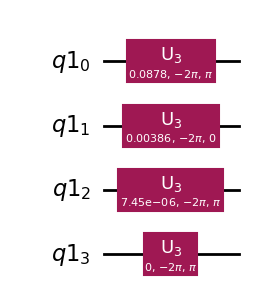

In [18]:
#from qasm to qiskit
qcirc4 = QuantumCircuit.from_qasm_str(qc4)
qcirc4.draw('mpl')

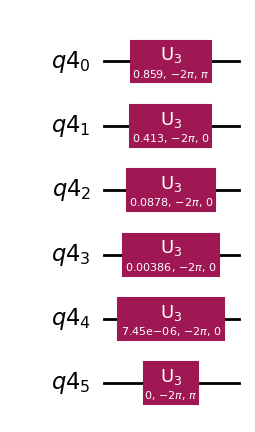

In [19]:
#from qasm to qiskit
qcirc6 = QuantumCircuit.from_qasm_str(qc6)
qcirc6.draw('mpl')

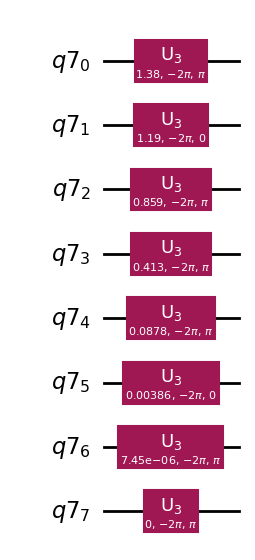

In [20]:
#from qasm to qiskit
qcirc8 = QuantumCircuit.from_qasm_str(qc8)
qcirc8.draw('mpl')

### Running the solution:

We will first define a function that recovers $u$ from $\psi$. This function uses finite difference.

In [21]:
def recover_u_from_psi(psi, dx, nu, epsilon=1e-10):
    """
    Recovers the velocity field u(x) from the scalar function psi(x) using the
    Cole-Hopf transformation, which involves calculating the spatial derivative
    of log(psi).

    The Cole-Hopf transformation is typically given by:
    u(x) = -2 * nu * (d/dx(log(psi(x))))

    This function approximates the derivative using a finite difference method.

    Args:
        psi (numpy.ndarray): A 1D NumPy array representing the scalar function psi(x).
                             It is assumed to be real-valued.
        dx (float): The spatial step size (delta x) between points in the psi array.
        nu (float): The kinematic viscosity parameter, a constant in the
                    Cole-Hopf transformation.
        epsilon (float, optional): A small positive value used to clip `psi`
                                   to prevent taking the logarithm of zero or
                                   negative numbers, which would result in
                                   NaN or infinite values. Defaults to 1e-10.

    Returns:
        numpy.ndarray: A 1D NumPy array representing the recovered velocity field u(x).
    """
    psi_clipped = np.clip(np.abs(psi), epsilon, None)
    log_psi = np.log(psi_clipped)

    dlog_psi_dx = (np.roll(log_psi, -1) - np.roll(log_psi, 1)) / (2 * dx)
    dlog_psi_dx[0] = (log_psi[1] - log_psi[0]) / dx
    dlog_psi_dx[-1] = (log_psi[-1] - log_psi[-2]) / dx

    return -2 * nu * dlog_psi_dx

In [22]:
# 4 qubits

In [23]:
# Parameters
N = 4  # N number of qubits => 2^N grid points
num_points = 2**N
L = 1.0
dx = L / (num_points)
x = np.linspace(0, L, num_points)
nu = 0.01
dt = 0.01

In [24]:
# Diffusion Operator (Hermitian Laplacian)
main_diag = -2.0 * np.ones(num_points)
off_diag = np.ones(num_points - 1)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray()
D = (nu / dx**2) * laplacian

# Normalize the diffusion operator
norm_factor = np.linalg.norm(D)
H = D / norm_factor

# Transform into a sparse pauli operator
op = Operator(H)
sparse_op = SparsePauliOp.from_operator(op, atol=1e-10)

In [25]:
qrte = TrotterQRTE(SuzukiTrotter(order=2))
problem = TimeEvolutionProblem(sparse_op, initial_state=qcirc4, time=dt*norm_factor)
result = qrte.evolve(problem)
statevector = Statevector(result.evolved_state)

psi_final = statevector.data
psi_final /= np.linalg.norm(psi_final)

u4_final = recover_u_from_psi(psi_final, dx, nu)

u4_final[0] = 1.0
u4_final[-1] = 0.0

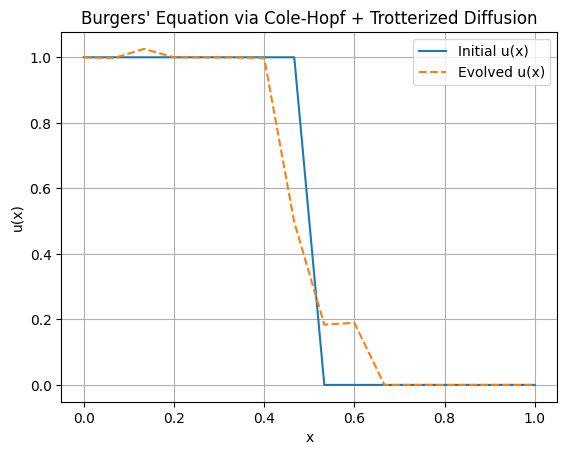

In [26]:
# --- Plot ---
plt.plot(x, u4, label="Initial u(x)")
plt.plot(x, u4_final, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion")
plt.show()

In [27]:
# 6 qubits

In [28]:
# Parameters
N = 6  # N number of qubits => 2^N grid points
num_points = 2**N
L = 1.0
dx = L / (num_points)
x = np.linspace(0, L, num_points)
nu = 0.01
dt = 0.01

In [29]:
# Diffusion Operator (Hermitian Laplacian)
main_diag = -2.0 * np.ones(num_points)
off_diag = np.ones(num_points - 1)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray()
D = (nu / dx**2) * laplacian

# Normalize the diffusion operator
norm_factor = np.linalg.norm(D)
H = D / norm_factor

# Transform into a sparse pauli operator
op = Operator(H)
sparse_op = SparsePauliOp.from_operator(op, atol=1e-10)

In [30]:
qrte = TrotterQRTE(SuzukiTrotter(order=2))
problem = TimeEvolutionProblem(sparse_op, initial_state=qcirc6, time=dt*norm_factor)
result = qrte.evolve(problem)
statevector = Statevector(result.evolved_state)

psi_final = statevector.data
psi_final /= np.linalg.norm(psi_final)

u6_final = recover_u_from_psi(psi_final, dx, nu)

u6_final[0] = 1.0
u6_final[-1] = 0.0

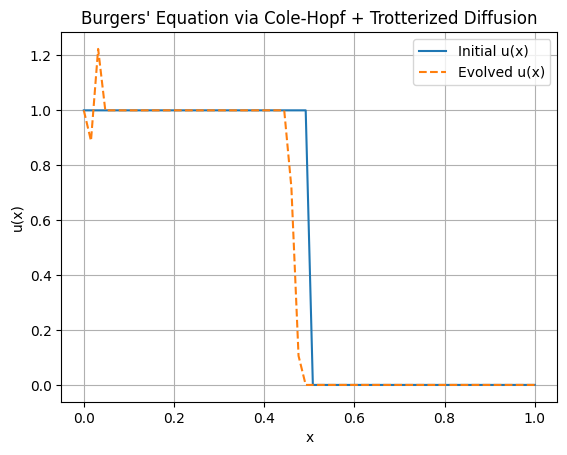

In [31]:
# --- Plot ---
plt.plot(x, u6, label="Initial u(x)")
plt.plot(x, u6_final, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion")
plt.show()

In [32]:
# 8 qubits

In [33]:
# Parameters
N = 8  # N number of qubits => 2^N grid points
num_points = 2**N
L = 1.0
dx = L / (num_points)
x = np.linspace(0, L, num_points)
nu = 0.01
dt = 0.01

In [34]:
# Diffusion Operator (Hermitian Laplacian)
main_diag = -2.0 * np.ones(num_points)
off_diag = np.ones(num_points - 1)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray()
D = (nu / dx**2) * laplacian

# Normalize the diffusion operator
norm_factor = np.linalg.norm(D)
H = D / norm_factor

# Transform into a sparse pauli operator
op = Operator(H)
sparse_op = SparsePauliOp.from_operator(op, atol=1e-10)

In [35]:
qrte = TrotterQRTE(SuzukiTrotter(order=2))
problem = TimeEvolutionProblem(sparse_op, initial_state=qcirc8, time=dt*norm_factor)
result = qrte.evolve(problem)
statevector = Statevector(result.evolved_state)

psi_final = statevector.data
psi_final /= np.linalg.norm(psi_final)

u8_final = recover_u_from_psi(psi_final, dx, nu)

u8_final[0] = 1.0
u8_final[-1] = 0.0

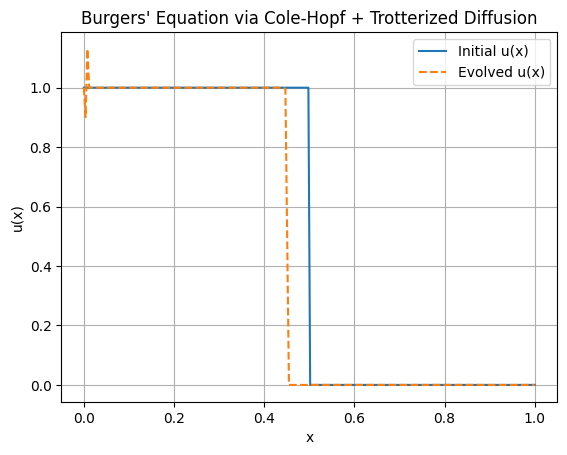

In [36]:
# --- Plot ---
plt.plot(x, u8, label="Initial u(x)")
plt.plot(x, u8_final, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion")
plt.show()

### Running for more than 1 step:

To run for several steps, we need to enforce dirichlet boundaries at each step, but then we will need to use the mps encoding after each one time step, this has a problem as the mps circuit is approximate and although fidelity is 99% or higher but each time we loose 0-1% of the vector, after 20 steps we can loose 10-20% of the vector which is alot.

A trick is to enforce boundary conditions at some steps, this is used in some CFD work when it is not viable to enforce dirichlet at every step. For example, If we run for 100 steps, we enforce dirichlet after 10 steps. Of course the fewer the better, but since MPS and has some inaccuracies we will use 10.

We will use the grid of 8 quibts, but we will change dt to be 0.5, in fact the shock wave in this solver does not move fast enough to the right so dt should be increased. This is something we explained previously in the quantum inspired notebook that it is not meaningful to compare solvers in the transient state but when they reach a stable or periodic state.

We will not explain the following code as it was explained before. We will run for 1 step but change dt to 0.5, then we will explain the next cells for running for more than 1 step.

We can clearly see that even with a step of 0.5 dt the graph did not move clearly to the right, so we will do 10 steps in the following cells.

The following steps are to be done:

1. Extract the circuit from the result.
2. Split the MPS circuit from the operator part of the circuit.
3. Retrieve the trotter operator circuit.
4. Append the operator circuit to the MPS circuit 10 times.

Then we get the statevector for 10 steps.

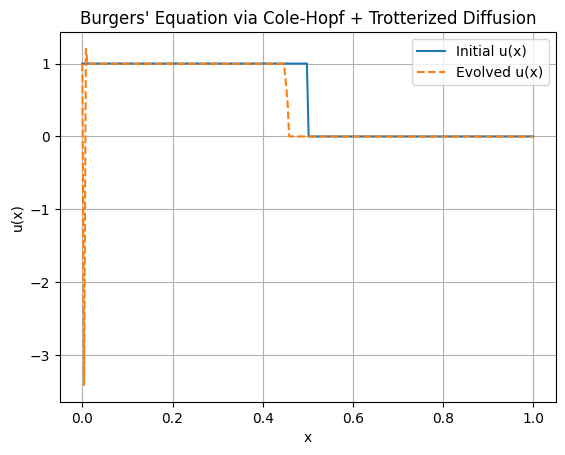

In [37]:
# Parameters
N = 8  # number of qubits => 2^N grid points
num_points = 2**N
L = 1.0
dx = L / (num_points - 1)
x = np.linspace(0, L, num_points)
nu = 0.01
dt = 0.5

# Diffusion Operator (Hermitian Laplacian)
main_diag = -2.0 * np.ones(num_points)
off_diag = np.ones(num_points - 1)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray()
D = (nu / dx**2) * laplacian

norm_factor = np.linalg.norm(D)
H = D / norm_factor

op = Operator(H)
sparse_op = SparsePauliOp.from_operator(op, atol=1e-10)


psi_sv = np.zeros(2**N, dtype=complex)
psi_sv[:] = psi8
psi_sv /= np.linalg.norm(psi_sv)
sv = Statevector(psi_sv)

sv = Statevector(qcirc8)

# --- Time Evolution ---
qrte = TrotterQRTE(SuzukiTrotter(order=2))
problem = TimeEvolutionProblem(sparse_op, initial_state=sv, time=dt*norm_factor)
result = qrte.evolve(problem)
statevector = Statevector(result.evolved_state)
sv = statevector
vec = statevector.data.copy()


psi_final = statevector.data
psi_final /= np.linalg.norm(psi_final)

u_final = recover_u_from_psi(psi_final, dx, nu)

u_final[0] = 1.0
u_final[-1] = 0.0

# --- Plot ---
plt.plot(x, u8, label="Initial u(x)")
plt.plot(x, u_final, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion")
plt.show()

In [38]:
filtered_qc = QuantumCircuit(8)
second_instruction = result.evolved_state.data[1]  # This is the PauliEvolution gate
filtered_qc.append(second_instruction.operation, second_instruction.qubits)

In [39]:
filtered_qc.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

As clearly seen above, we have successfully extracted only the second gate which is the pauli evolution gate without the gate for the initial MPS circuit. Now we will append this gate to the MPS circuit 10 times to make 10 steps and then we plot.

In [40]:
filtered_qcirc8 = qcirc8.copy()
for i in range(10):
    filtered_qcirc8.append(filtered_qc, range(8))

After the 10 steps are finished, dirichlet boundaries are enforced using the following code:

u8_final[0] = 1.0

u8_final[-1] = 0.0

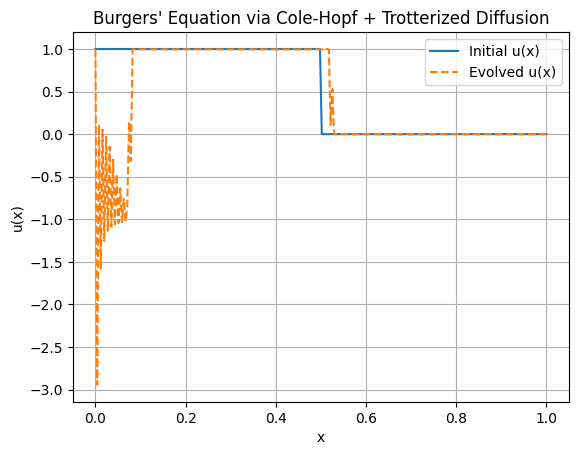

In [41]:
psi_final = Statevector(filtered_qcirc8).data
psi_final /= np.linalg.norm(psi_final)

u8_final = recover_u_from_psi(psi_final, dx, nu)

# Enforcing dirichlet boundaries
u8_final[0] = 1.0
u8_final[-1] = 0.0

# --- Plot ---
plt.plot(x, u8, label="Initial u(x)")
plt.plot(x, u8_final, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion")
plt.show()

We can also transform the trotter operator circuit or the full circuit into qasm. This is useful especially in the benchmarking when we are going to benchmark different algorithms later, as to not write the code for all the algorithms in the same notebook.

In [42]:
# export QASM2
qct = transpile(filtered_qc, basis_gates=['u3', 'cx'], optimization_level=0)
qasm_str = qasm2.dumps(qct)

# write to file
with open("trotter_operator.qasm", "w") as f:
    f.write(qasm_str)

### References:

1. Qiskit Trotterization tutorial: <a href="https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html">Link</a>
2. Quantum-inspired framework for computational fluid dynamics: <a href="https://www.nature.com/articles/s42005-024-01623-8">Link</a>
3. Qmprs tool: <a href="https://github.com/Qualition/qmprs">Link</a>

### Versions:

In [43]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [44]:
import pkg_resources

# Loop through installed packages and filter those starting with 'qiskit'
for dist in pkg_resources.working_set:
    if dist.project_name.lower().startswith("qiskit"):
        print(f"{dist.project_name} == {dist.version}")

qiskit == 1.3.1
qiskit-aer == 0.16.0
qiskit-algorithms == 0.3.1
qiskit-ibm-runtime == 0.34.0
qiskit-qasm3-import == 0.6.0
qiskit-transpiler-service == 0.4.14


In [45]:
from importlib.metadata import version

print(version("qmprs"))

0.0.0rc0
